# BeepTweet Text to VAD model
 This code is supposed to demonstrate how code for first model works
 Brief description: this regression model takes sentences labelled with VAD values, trains on it and predicts labels on unseen data

In [41]:
# Import main Dataset called Emobank
import pandas as pd
eb = pd.read_csv("emobank.csv", index_col=0 ,engine='python')

In [42]:
# Basic EDA
# Reset default index
eb.reset_index(drop=True, inplace=True)

# Going to use our own split
eb = eb.drop(labels='split', axis=1)

In [43]:
# Extract VAD values
y_V = eb['V']
y_A = eb['A']
y_D = eb['D']

In [44]:
# Text to a list for cleaning
eb_list = eb['text'].values.tolist()

# Explonatory Data Analysis

In [45]:
import numpy as np
array_V = y_V.values.tolist()
array_A = y_A.values.tolist()
array_D = y_D.values.tolist()

array_V = np.array(array_V)
array_A = np.array(array_A)
array_D = np.array(array_D)
array = np.stack((array_V.T, array_A.T, array_D.T), axis=1)

bin_values = np.arange(start=1, stop=5, step=0.1)

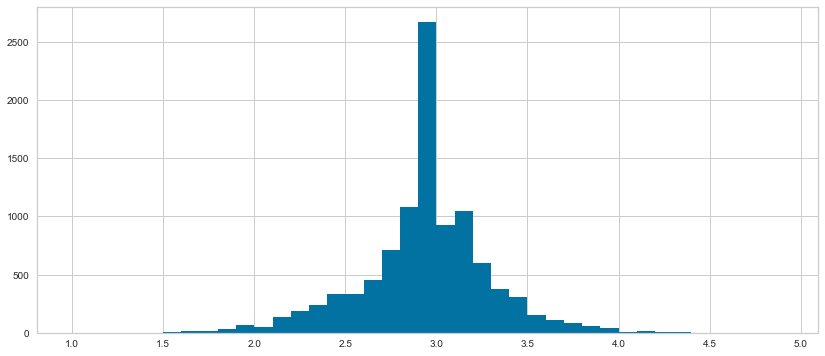

In [46]:
y_V.hist(bins=bin_values, figsize=[14,6])

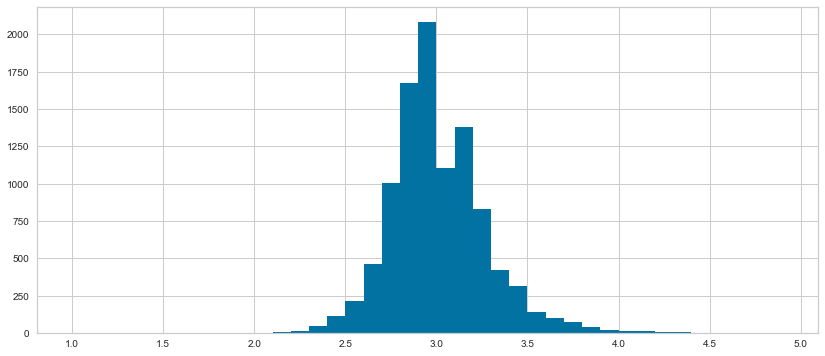

In [47]:
y_A.hist(bins=bin_values, figsize=[14,6])

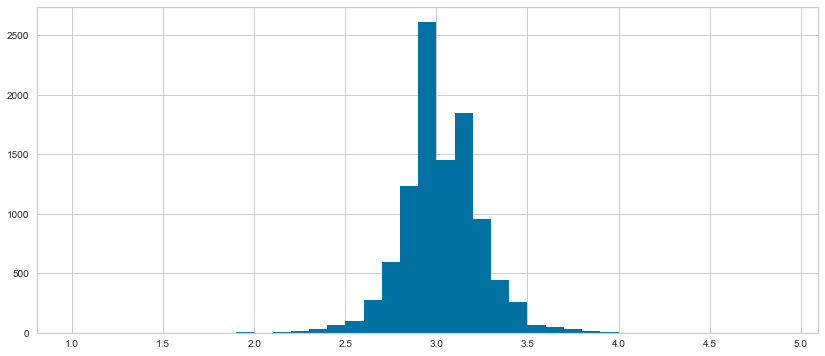

In [48]:
y_D.hist(bins=bin_values, figsize=[14,6])

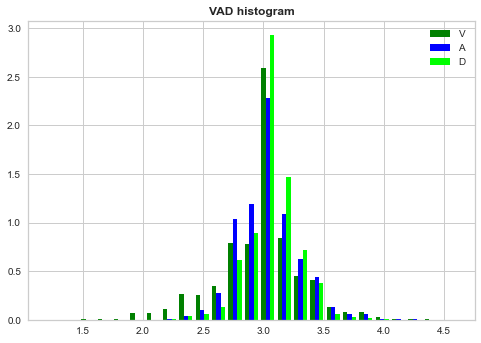

In [49]:
import matplotlib
import matplotlib.pyplot as plt
    
    
colors2 = ['green', 'blue', 'lime']
  
plt.hist(array, 25, density = True, 
         histtype ='bar',
         color = colors2,
         label = ['V','A','D'])
  
plt.legend(prop ={'size': 10})
  
plt.title('VAD histogram',
          fontweight ="bold")
  
plt.show()

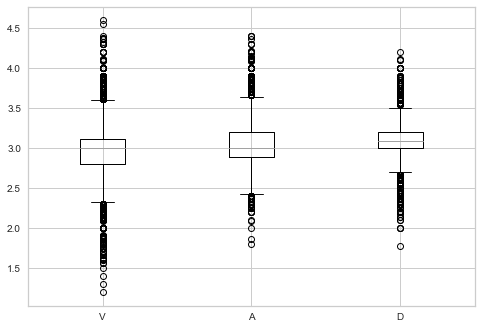

In [50]:
df = eb.drop(columns = "text", axis=1)
df.boxplot()

# Preprocessing

In [51]:
# Data cleaning function

# This cell code is based on: https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90

from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import re
def clean(eb_list):
    i=0
    tok = WordPunctTokenizer()
    pat1 = r'@[A-Za-z0-9]+'
    pat2 = r'https?://[A-Za-z0-9./]+'
    combined_pat = r'|'.join((pat1, pat2))
    def tweet_cleaner(text):
        soup = BeautifulSoup(text, 'html.parser')
        souped = soup.get_text()
        stripped = re.sub(combined_pat, '', souped)
        try:
            clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
        except:
            clean = stripped
        letters_only = re.sub("[^a-zA-Z]", " ", clean)

        # Here is our function that we added
        # Purpose is to keep word in upper case if it has more than one subsequent upper letter
        # We think subsequent upper case letters adds significantly to sentiment value

        i=0
        lower_case=""
        for n in letters_only:
            if i==0:
                if n.isupper() == True :
                    i=1
                    save = n
                else:
                    lower_case += n.lower()
            elif i==1:
                if n.isupper():
                    i=2
                    lower_case += save
                    lower_case += n
                else:
                    lower_case += save.lower()
                    lower_case += n.lower()
                    i=0
            elif i==2:
                lower_case += n
                if n==" ":
                    i=0
            else:
                lower_case += n.lower()

        # --- Our code ends here ---#

        words = tok.tokenize(lower_case)
        return (" ".join(words)).strip()
    testing = eb_list
    test_result = []
    for t in testing:
        test_result.append(tweet_cleaner(t))
    return test_result

In [52]:
test_result = clean(eb_list)

c:\users\justs\appdata\local\programs\python\python37\lib\site-packages\bs4\__init__.py:438: MarkupResemblesLocatorWarning: "http://www.law.com/jsp/nlj/PubArticleNLJ.jsp?id=1202463630848&Alcohol_bill_means_happy_hour_for_lobbyists" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
c:\users\justs\appdata\local\programs\python\python37\lib\site-packages\bs4\__init__.py:343: MarkupResemblesLocatorWarning: "." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


# Feature Extraction

In [53]:
# Feature extraction function that I have decided to use after some experiments

# Preprocessing function with Tf-idf
# Based on code from:
# https://developers.google.com/machine-learning/guides/text-classification/step-3
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts. This way no leaking of information is done.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [54]:
# Text for each VAD so it doesnt overlap
eb_list_V = test_result
eb_list_A = test_result
eb_list_D = test_result

In [55]:
# Split Data
from sklearn.model_selection import train_test_split

X_Vtrain_pre, X_Vtest, y_Vtrain, y_Vtest = train_test_split(eb_list_V, y_V, test_size=0.15)
X_Atrain_pre, X_Atest, y_Atrain, y_Atest = train_test_split(eb_list_A, y_A, test_size=0.15)
X_Dtrain_pre, X_Dtest, y_Dtrain, y_Dtest = train_test_split(eb_list_D, y_D, test_size=0.15)

In [56]:
# Preprocess the data with feature extraction function
X_Vtrain, X_Vtest = ngram_vectorize(X_Vtrain_pre, y_Vtrain, X_Vtest)
X_Atrain, X_Atest = ngram_vectorize(X_Atrain_pre, y_Atrain, X_Atest)
X_Dtrain, X_Dtest = ngram_vectorize(X_Dtrain_pre, y_Dtrain, X_Dtest)

# Fit Model

In [57]:
# After doing hyper tunning we found that best solver is sag
# and regulization strength is best at 1, 2.5, 3# 
# So now I will change the models to be better and evaluate them again
# Model training
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
clf4 = Ridge(solver='sag', alpha=1, max_iter = 5000)
clf5 = Ridge(solver='sag', alpha=2.5, max_iter = 5000)
clf6 = Ridge(solver='sag', alpha=3, max_iter = 5000)
clf4 = clf4.fit(X_Vtrain, y_Vtrain) 
clf5 = clf5.fit(X_Atrain, y_Atrain)
clf6 = clf6.fit(X_Dtrain, y_Dtrain) 

# Evaluation

In [58]:
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

In [59]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
scores_V = cross_val_score(clf4, X_Vtrain, y_Vtrain, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atrain, y_Atrain, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtrain, y_Dtrain, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# report performance
print('Valence train mse: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal train mse: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance train mse: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))
print("")

scores_V = cross_val_score(clf4, X_Vtest, y_Vtest, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atest, y_Atest, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtest, y_Dtest, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# report performance
print('Valence test mse: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal test mse: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance test mse: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))
print("")

scores_V = cross_val_score(clf4, X_Vtrain, y_Vtrain, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atrain, y_Atrain, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtrain, y_Dtrain, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# report performance
print('Valence train mae: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal train mae: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance train mae: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))
print("")

scores_V = cross_val_score(clf4, X_Vtest, y_Vtest, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atest, y_Atest, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtest, y_Dtest, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# report performance
print('Valence test mae: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal test mae: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance test mae: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))
print("")

Valence train mse: -0.086 (0.004)
Arousal train mse: -0.060 (0.002)
Dominance train mse: -0.041 (0.001)

Valence test mse: -0.110 (0.011)
Arousal test mse: -0.061 (0.007)
Dominance test mse: -0.043 (0.004)

Valence train mae: -0.209 (0.004)
Arousal train mae: -0.185 (0.003)
Dominance train mae: -0.150 (0.002)

Valence test mae: -0.240 (0.012)
Arousal test mae: -0.190 (0.010)
Dominance test mae: -0.153 (0.007)



In [60]:
V_values = clf4.predict(X_Vtest)
A_values = clf5.predict(X_Atest)
D_values = clf6.predict(X_Dtest)

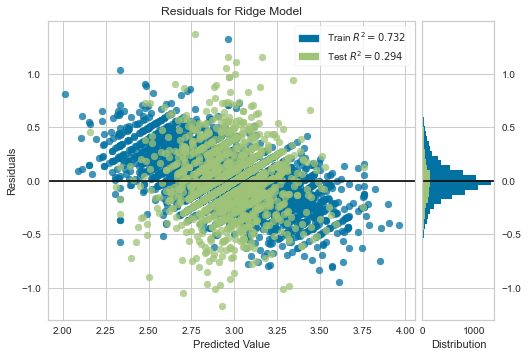

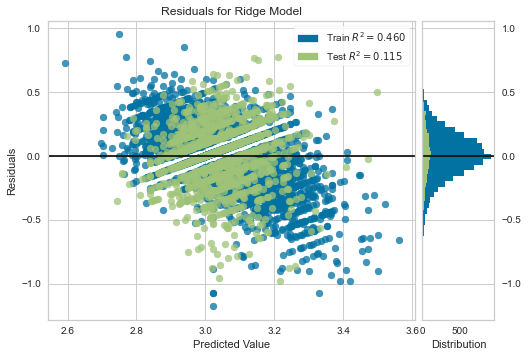

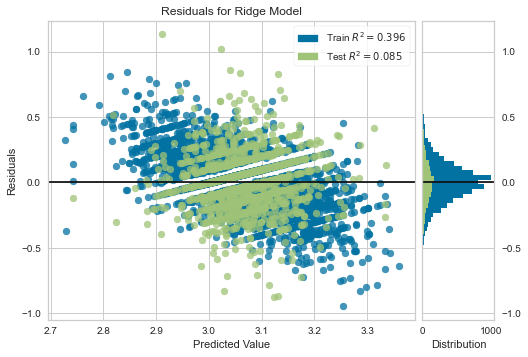

In [61]:
from yellowbrick.regressor import residuals_plot
viz_V_2 = residuals_plot(clf4, X_Vtrain, y_Vtrain, X_Vtest, y_Vtest)
viz_A_2 = residuals_plot(clf5, X_Atrain, y_Atrain, X_Atest, y_Atest)
viz_D_2 = residuals_plot(clf6, X_Dtrain, y_Dtrain, X_Dtest, y_Dtest)

# Writting our own tweets and evaluating

In [62]:
tweets = ["Everyone grown until it’s time to apologize #sad",
          "THIS CANNOT BE THE GAME THAT HAPPENS THE DAY I FIND OUT MY SON KNOCKED UP HIS TUTOR!!! #angry #camtgetanyworse",
          "Sending healing love and hugs to Jasmina. Let go of that little girl and let more love in. You deserve it!!! #proud #wearenotourpast #MarriedAtFirstSight",
          "I feel calm relaxed and easy",
          "Positive and calm"
         ]

In [63]:
clean_tweets = clean(tweets)

In [64]:
X_Vtrain, tweets_V = ngram_vectorize(X_Vtrain_pre, y_Vtrain, clean_tweets)
X_Atrain, tweets_A = ngram_vectorize(X_Atrain_pre, y_Atrain, clean_tweets)
X_Dtrain, tweets_D = ngram_vectorize(X_Dtrain_pre, y_Dtrain, clean_tweets)

In [75]:
tweets_V


<640x20000 sparse matrix of type '<class 'numpy.float32'>'
	with 12953 stored elements in Compressed Sparse Row format>

In [66]:
V_values = clf4.predict(tweets_V)
A_values = clf5.predict(tweets_A)
D_values = clf6.predict(tweets_D)

In [67]:
# Normalize values between -1 and 1
V_values = [(float(i)-3)/2 for i in V_values]
A_values = [(float(i)-3)/2 for i in A_values]
D_values = [(float(i)-3)/2 for i in D_values]

In [68]:
import pandas as pd
df = pd.DataFrame(list(zip(tweets, V_values, A_values, D_values)),
                 columns = ['Tweet', 'Valence', 'Arousal', 'Dominance'])

In [69]:
# While evaluating ourself we followed this rule of thumb
# High Valence - positive emotions
# Low Valence - negative emotions
# High Arousal - A lot of energy
# Low Arousal - low energy
# High Dominance - About to do something like Anger
# Low Dominance - Fear
df

,Tweet,Valence,Arousal,Dominance
0,Everyone grown until it’s time to apologize #sad,-0.137950,0.074161,0.029370
1,THIS CANNOT BE THE GAME THAT HAPPENS THE DAY I...,-0.104131,0.086768,0.066590
2,Sending healing love and hugs to Jasmina. Let ...,0.304400,0.168295,0.137800
3,I feel calm relaxed and easy,0.040518,-0.030129,0.008948
4,Positive and calm,0.170715,-0.026564,0.055636


# Save preproccessed data and models

In [79]:
import pandas as pd
tweets = pd.read_csv("data_for_showcase.csv", index_col=0 ,engine='python')

In [80]:
tweets= tweets.index.values.tolist()
clean_tweets = clean(tweets)

In [81]:
X_Vtrain, tweets_V = ngram_vectorize(X_Vtrain_pre, y_Vtrain, clean_tweets)
X_Atrain, tweets_A = ngram_vectorize(X_Atrain_pre, y_Atrain, clean_tweets)
X_Dtrain, tweets_D = ngram_vectorize(X_Dtrain_pre, y_Dtrain, clean_tweets)

In [82]:
from scipy import sparse
sparse.save_npz("proc_V.npz", tweets_V)
sparse.save_npz("proc_A.npz", tweets_A)
sparse.save_npz("proc_D.npz", tweets_D)

In [83]:
import pickle
filename_V = 'finalized_model_V.sav'
filename_A = 'finalized_model_A.sav'
filename_D = 'finalized_model_D.sav'
pickle.dump(clf4, open(filename_V, 'wb'))
pickle.dump(clf5, open(filename_A, 'wb'))
pickle.dump(clf6, open(filename_D, 'wb'))